## 1. Hashing task!

* We've put all passwords from passwords1.txt and passwords2.txt  in two lists: listPasswords1 and listPasswords2

In [1]:
listPasswords1=[]
listPasswords2=[]
filePassword1 = open("passwords1.txt", 'r')
lines_p1 = filePassword1.readlines()
for line in lines_p1:
    listPasswords1.append(line.strip())

filePassword2 = open("passwords2.txt", 'r')
lines_p2 = filePassword2.readlines()
for line in lines_p2:
    listPasswords2.append(line.strip())



We have set all variables that we need to build our Bloom Filter:
* n = Number of items in the filter
* p = Probability of false positives, fraction between 0 and 1
* m = Number of bits in the filter (size of Bloom Filter bit-array)
* k = Number of hash functions

We did these following considerations:
N is the amount of passwords that are in passwordss1.txt (i.e. in listPasswords1).
We need to calculate p,m and k from following formulas:
\begin{align*}
k = (m/n)*ln(2)
\end{align*}

\begin{align*}
m = ((n*ln(p)) / (ln(2))^2
\end{align*}

Since we don't know the value of any previous varaibles, from https://hackernoon.com/probabilistic-data-structures-bloom-filter-5374112a7832 (suggested link in track) we have set initially p=0.0015. P must be a valuue between 0 and 1. With smaller value of p, we have a lower probability to have a false positives in search on bloom filter. 
Bloom filter can have false positives and NOT false negatives. We have choosen this value (0.0015) from a different test that we have tryed. We think that it should be an optimal value to have also optimal values about k and m.
Funally we calculated k and m (with previous formulas).

In [2]:
n=len(listPasswords1)
p=0.01
import math
m=math.ceil((n * math.log(p)) / math.log(1 / pow(2, math.log(2))))
k = round((m / n) * math.log(2))

This following function is our hash function. We have written from scratch our fnv function based on fnv hash function. FNV hashes are designed to be fast while maintaining a low collision rate. The FNV speed allows one to quickly hash lots of data while maintaining a reasonable collision rate. 
To build bloom filter we need of various hash functions that should be independent, uniformly distributed and fast.
From previous formulas, we have calculated the number of different hash functions that we should use. We set a variable, called 'seed' that is an integer from 0 to k(number of hash functions); in this way we'll have k different hash fucntions that transform our input string in k different number. These k numbers will be the index of our bit-array that represent respective inout password.

The initial values of 'FNV_prime' and 'offset_basis' are taken from this wikipedia page: https://en.wikipedia.org/wiki/Fowler–Noll–Vo_hash_function in 'FNV hash parameters'.


In [3]:
def fnv1_64(password, seed=0):
    """
    Returns: The FNV-1 hash of a given string. 
    """
    #Constants
    FNV_prime = 1099511628211
    offset_basis = 14695981039346656037

    #FNV-1a Hash Function
    hash = offset_basis + seed
    for char in password:
        hash = hash * FNV_prime
        hash = hash ^ ord(char)
    return hash




This following class 'BloomFilter' represent out Bloom Filter. 

It has three attributes:
* sizeArray = dimension of bit-array
* number_HashFucntion = number of hash functions
* array_BloomFilter = bit-array of bloom filter

It has also two methods:
* init: it takes, as parameteers ouur bloom filter, k (number of hash functions that we have calculated from previous formula), m  (size of bit-array that we have calculated with  previous function). It initializes the bit-array of Bloom filter (size=m) with all '0'; its size with m and its number of hash functions with k.
* add: this method allow to add an element from input list to our bloom filter. It takes this list and our bloom filter as parameters and it calculates the effective bit-array with right '1' and '0'.

In [4]:
class BloomFilter:

    sizeArray=0
    number_HashFucntion=0
    array_BloomFilter=[]
    
    @property
    def size(self):
        return self.sizeArray
    @property
    def numHash(self):
        return self.number_HashFucntion
    @property
    def arrayBloom(self):
        return self.array_BloomFilter
    
    def init(self,k,m):
        self.sizeArray=m
        self.number_HashFucntion=k
        
        for i in range(m):
            self.array_BloomFilter.append(0)
    
    def add(self,strings):
        #print(self.number_HashFucntion)
        #print(self.sizeArray)
        h=0
        for psw in strings:
            
            for seed in range(self.number_HashFucntion):
                index=fnv1_64(psw,seed) % self.sizeArray
                
                self.array_BloomFilter[index]=1

Then we made a function 'checkPassw' that checks how many password in listPasswords2 (i.e. in passowrds2.txt) are in our Bloom Filter. It takes our bloom filter and the list of passwords that are in passwords2.txt and it returns how many passwords are in bloom filter. 
A password is in our bloom filter if and only if its conversion with hash functions coresponds to every '1' in the bit-array. If there is only one '0', current password is not in bloom filter.

'countCheck' is the number of occurences of passwords (from passwords2.txt) in bloom filter. This number represent the occurences of passwords from passwords2.txt that are 'probably' in password1.txt

In [5]:
def checkPassw(BloomFilter, listPasswords2):
    countCheck=0
    for psw in listPasswords2:
        count=0
        for seed in range(BloomFilter.number_HashFucntion):
            index=fnv1_64(psw,seed) % BloomFilter.sizeArray
            if BloomFilter.array_BloomFilter[index]==1:
                count+=1
            if count==BloomFilter.number_HashFucntion:
                countCheck+=1
            
    return countCheck

## Bonus section: 
###### We calculate the number of false positive

This following function 'falsePositives' allows to calculate the exact number of false positive. It takes these following data, as parameter:
* Bloom Filter = our bloom filter
* listPassowrds1 = passwords from passwords1.txt
* listPassowrds2 = passwords from passwords2.txt

For every password in listPasswords2, we check if current password is in the bloom filter. Then if this password is in bloom filter, it means that it is 'probably' in listPasswords2. 
With conversion through hash functions, If there is only one '0'in bloom filter, it means that this current password is not in bloom filter.

To check if it's a false positive (i.e. it is in bloom fileter but it is not in listPasswords1), we'll continue to verify if this current password is in listPassword1. If it's true, it means that it is a False psiitive and we increment our counter 'countFalsePositives'; if it's True it means this password is actually in listPassword1 nad we continue with next password in listPassword2.
We used a set to verify if a password is in listPassword1,  beacuse it's faster to find an element in large list. So we get a set 's' from listPassword1. This following link contains a figure that shows the reason to use a set to find an element in a large collection of data than a simple list. 
     
https://stackoverflow.com/questions/7571635/fastest-way-to-check-if-a-value-exists-in-a-list

In [11]:
def falsePositives(BloomFilter, listPasswords1, listPasswords2):
    s= set(listPasswords1)
    countFalsePositives=0
    
    for psw in listPasswords2:
        count=0
        for seed in range(BloomFilter.number_HashFucntion):
            index=fnv1_64(psw,seed) % BloomFilter.sizeArray
            if (BloomFilter.array_BloomFilter[index]==1):
                    count+=1
            else:
                break
            if count==BloomFilter.number_HashFucntion:
                if not(psw in s):
                    countFalsePositives+=1
                    #print(psw)
    return countFalsePositives
                

Then we did the main function, as wirtten in homework track. With this function we did these following steps:
* init bit-array, its size adn number of hash functions of our bloom filter, with 'BloomFilter.init(BloomFilter,k,m)'
* add passowrds from listPasswords1 into our bloom filter, with 'BloomFilter.add(BloomFilter,listPasswords1)'
* calculate how many passwords (from passwords2.txt) are present in our bloom filter, with 'checkPassw(BloomFilter,listPasswords2)'

###### Finally we print these following functions:
* Number of hash function used
* Number of duplicates detected
* Probability of false positives
* Execution time

In [7]:
import time

def BloomFilterFunc(listPasswords1, listPasswords2):
    start = time.time()
    #init our bloom filter
    BloomFilter.init(BloomFilter,k,m)
    #add all passowrd from listPassowrds1 to our bloom filter
    BloomFilter.add(BloomFilter,listPasswords1)
    #check and save into 'countPassw' the number of occurences of password (from passwords2) in the bloom filter
    countPassw=checkPassw(BloomFilter,listPasswords2)
    end = time.time()
    
    #print output data
    
    
    print('Number of hash function used: ', k)
    print('Number of duplicates detected: ', countPassw)
    print('Probability of false positives: ', p)
    print('Execution time: ', end-start)
    



* Execute main function

In [8]:
BloomFilterFunc(listPasswords1, listPasswords2)

Number of hash function used:  7
Number of duplicates detected:  14251447
Probability of false positives:  0.01
Execution time:  4041.6586632728577


* Execute bonus section

In [12]:
falsPositive=falsePositives(BloomFilter,listPasswords1,listPasswords2)

In [13]:
print('Number of false positive: ', falsPositive)

Number of false positive:  251447


# 2. Alphabetical Sort

Given a set of words, a common natural task is the one of sorting them in alphabetical order. It is something that you have for sure already done once in your life, using your own algorithm without maybe knowing it.

In order to be everyone on the same page, we will refer to the rules defined here. As for multi-word string, let stick with the first plicy proposed there.

What you might know is that we can relate this task to a simple algorithm that runs in linear time: Counting Sort. Counting Sort is based on a simple assumption: you know the range of the possible values of the instances you have to sort. In this exercise you are asked to perform Alphabetical Sort exploiting the algorithm of Counting Sort.

In [338]:
import string
improt numpay as np
lower = list(string.ascii_lowercase)
upper = string.ascii_uppercase

In [295]:
lower

'abcdefghijklmnopqrstuvwxyz'

Build your own implementation of Counting Sort...

Here is the counting sort algorithm with  a bite innovation and fewer assignments than the original one explained in the attached website to the hw

In [1050]:
def s_counting(A):   
    m = max(A)
    sorted_A = []
    temp = 0
    d = [0]*(m+1)
    
    for i in range(len(A)):
        d[A[i]]+=1

    for x,y in enumerate(d):
        sorted_A += [x]*y 
    return sorted_A       

In [332]:
A = [0,3,2,3,3,0,5,2,3]
sort_counting(A)

[0, 0, 2, 2, 3, 3, 3, 3, 5]

Build an algorithm, based on your implementation of Counting Sort, that receives in input a list with all the letters of the alphabet (not in alphabetical order), and returns the list ordered according to alphabetical order

We continue the same approch as first part here and keep 

In [1051]:
def sort_letters(B):
    B = list( ''.join(B).lower())
    m = len(B)
    d = []
    sorted_letters = []
    for i in B:
        d.append(lower.index(i)) 
    c = s_counting(d)
    for j in c:
        sorted_letters += lower[j]
    return sorted_letters       

In [1052]:
B = ['p' , 'w' , 'x', 'k' , 'p' , 'a' , 'c' ,'a' , 'b' , 'a' , 'c']
sort_letters(B)

['a', 'a', 'a', 'b', 'c', 'c', 'k', 'p', 'p', 'w', 'x']

Build an algorithm, based on your implementation of Counting Sort, that receives in input a list of length m, that contains words with maximum length equal to n, and returns the list ordered according to alphabetical order.

Here is the first algurithim try to follow the counting sort algurithim order, is our first approch to do it.. 

In [1036]:
Lower = lower.copy()
Lower.insert(0,'') 

C  = ['words' , 'amount' , 'efficiently' , 'thumb' , 'rule' , 'solvable' ,  'Another' ,'open' ,'problem', 'is' ,'whether']
C = [a.lower() for a in C]
m = max([len(e) for e in C])
d = [[] for _ in C]


for i in range(len(C)):
    w2l = list(C[i])
    l2num = [Lower.index(a) for a in w2l ]
    d[i] = l2num + [0]*(m-len(l2num))

sorted_d =[[] for _ in d]    
for x in reversed(range(m)):
    count = [0]*len(Lower)
    cum_count = [0]*len(Lower)
    
    
    for e in range(len(d)):
        count[d[e][x]]+=1
        
      
    for r in range(len(count)):
        if count[r]>0:
            for g in range(len(d)):
                if r ==d[g][x]:
                    sorted_d.append( d[g])
final_sort = []                   
for h in sorted_d[-len(d):]:
    final_sort.append( ''.join([Lower[a] for a in h]))
    
        
        
print(final_sort)   

['amount', 'another', 'efficiently', 'is', 'open', 'problem', 'rule', 'solvable', 'thumb', 'words', 'whether']


Here in this algorithm, we have some limitation due to the big numbers, We tried to fix the problem with normalizing the numbers between and 1000 however this will only could distinguish the words which are equal at 3 to 5 letters and after that, it would be really time-consuming to calculate and normally end up with errors

In [1034]:
x = ['words' , 'amount' , 'are' , 'efficiently' , 'thumb' , 'rule' , 'solvable' ,  'Another' ,'open' ,'problem', 'is' ,'whether']
#x = ['asd', 'bedf','mog','zor','bze']
#x = input('Enter the words, seperated by comma(,)').split(',')
x_2 = x.copy()

# Finding the longest word
max_length = 0
for i in x:
    if max_length < len(list(i)):
        max_length = len(list(i))
    

# Turning words to numbers
for i in range(len(x)):
    x[i] = convert_w_2_n(x[i], max_length)
    

#Normalize between 0 to 1000

mx = max(x)
mn = min(x)
for i,j in enumerate(x):
    x[i] = int((10**(3))*(j-mn)/(mx-mn))
    
    

max_int = max(x)
aux_array = [0]*(max_int+1)
aux_array_2 = aux_array


# Step 1 : counting
for i in x:
    aux_array[i] = aux_array[i] + 1
    
# Step 2 : comulating
aux_array_2[0] = aux_array[0]
for i in range(1,max_int+1):
    aux_array_2[i] = aux_array_2[i-1] + aux_array[i]
    
# Sorting
final_list = ['']*len(x)
for i in reversed(range(len(x))): #e.g:  i = 2, 1, 0 
    final_list[aux_array_2[x[i]]-1] = x_2[i]
    aux_array_2[x[i]] = aux_array_2[x[i]] -1
    
    
    
print(final_list)

['Another', 'amount', 'are', 'efficiently', 'is', 'open', 'problem', 'rule', 'solvable', 'thumb', 'whether', 'words']


# Final version with best performance and without any limitation

Here we rewirte the count sorting algurithim again and we keep the order
Order is the origilanl list index wich if we use order list as a index we can soert it, it shows how the elements moves from where to wher to have the final arry

In [962]:
#sorting

def sort_counting(A):   
    m = max(A)
    sorted_A = []
    temp = 0
    d = [0]*(m+1)
    
    for i in range(len(A)):
        d[A[i]]+=1
    
    cum_d =[0]*(m+1)
    for i in d:
        cum_d.append(i)  
        
    order = list()
    for x,y in enumerate(d):
        sorted_A += [x]*y
        for i in range(y):
            order.append(A.index(x))
            A[order[-1]] = -1


    return sorted_A , order  

# Now  we use the counting sort algruthin and it's order to make this work
We have used pure counting sort algurtim and keep the $big O$ time still in $O(n)$ 
Howerver the total time it use is $T(n) = kn+c$ 

the one is exatly same big O and principle as counting sort

In [1029]:
Lower = lower.copy()
Lower.insert(0,'') 
import numpy as np

C  = [  'Alessio', 'Alessandro' , 'Angela', 'Alessand','Anita', 'Anna','Alessandrx', 'Arianna' ,'Alessandra']
C = [a.lower() for a in C]
m = max([len(e) for e in C])
d = [[] for _ in C]
final_sort = C.copy()

for i in range(len(C)):
    w2l = list(C[i])
    l2num = [Lower.index(a) for a in w2l ]
    d[i] = l2num + [0]*(m-len(l2num))

dd = np.array(d)    
for x in reversed(range(m)):
    count, order = sort_counting(list(dd[: ,x]))
    temp = [[] for _ in  d]
    temp_sort = final_sort.copy()
    
    for i,j in enumerate(order):
        temp[i] += list(dd[j])
        
        final_sort[i] =temp_sort[j]
            
    dd = np.array(temp)     
        
            
final_sort  

['alessand',
 'alessandra',
 'alessandro',
 'alessandrx',
 'alessio',
 'angela',
 'anita',
 'anna',
 'arianna']

# 3. Find similar wines!

#### Imports

In [1]:
import random

import pandas as pd

import numpy as np

from collections import defaultdict

import matplotlib

import matplotlib.pyplot as plt

## Functions created for implementing the kMeans 

#### Create the Euclidean distance 

In [3]:
def distance_2(vec1, vec2):
    
    if len(vec1) == len(vec2):
        
        if len(vec1) > 1:
            
            add = 0
            
            for i in range(len(vec1)):
                
                add = add + (vec1[i] - vec2[i])**2
                
            return add**(1/2)
        
        else:
            
            return abs(vec1 - vec2)
        
    else:
        
        return "Wrong Input"
    

#### We will now check the dissimilarity of our clusters. To do that we need to define the variability of every cluster. Meaning the sum of the distances of every element in the cluster from the mean(centroid). 

In [4]:
def dissimilarity(cluster):
    
    def kmeansreduce(centroid, dictionary):
        
        a = dictionary[centroid] 
    
        if len(a) > 0 :
        
            vector = a[0]
        
            for i in range(1,len(a)):
            
                vector = np.add(vector, a[i])
                        
            return vector
        
        else:
            
            pass
    
    var = []
    
    add = 0
    
    for i in range(len(cluster.keys())):
        
        if len(cluster[i]) > 0:
            
            m = kmeansreduce(i, cluster) / len(cluster[i])
        
            for j in range(len(cluster[i])):
            
                add = add + distance_2(m, cluster[i][j])
            
    return(add)

#### Compute the sum of the squared distance between data points and all centroids (distance_2).  
#### Assign each data point to the closest cluster (clusters dictionary).
#### Compute the centroids for the clusters by taking the average of the all data points that belong to each cluster.(initial centroids)
#### We define also two functions to show that this algorithm can be done by MapReduce method

In [5]:
def kmeans(data, k):
    
    def kmeansmap(information, num_centroids, centroids):
        
        clusters = defaultdict(list)
        
        for i in range(num_centroids):
            
            clusters[i] = []

        classes = defaultdict(list)
        
        for i in range(information.shape[0]): 
            
            d = []
            
            for j in range(num_centroids):
                
                d.append(distance_2(information[i,], centroids[j]))
                
            clusters[np.argmin(d,axis=0)].append(information[i,])
            
            classes[i].append(np.argmin(d,axis=0))
            
        return [clusters, classes]
        
        
    def kmeansreduce(centroid, dictionary):
        
        a = dictionary[centroid] 
    
        if len(a) > 0 :
        
            vector = a[0]
        
            for i in range(1,len(a)):
            
                vector = np.add(vector, a[i])
                        
            return vector
        
        else:
            
            pass

            
        # ===================================================================================
        
    initial_centroids = random.sample(list(data), k)

    while True:
        
        dict1 = kmeansmap(data, k, initial_centroids)[0]
        
        dict2 = kmeansmap(data, k, initial_centroids)[1]
        
        dict3 = defaultdict(list)
        
        for i in range(k):
            
            dict3[i] = []
                        
        old_clusters = initial_centroids
        
        for i in range(k):
            
            dict3[i] = kmeansreduce(i, dict1)
            
            if len(dict3[i]) > 0:
                
                initial_centroids[i] =  dict3[i]/len(dict3[i])                       
                
        if old_clusters == initial_centroids:
            
            break
            
    return [dict1, dict2]
    

# Now we will implement the algorithms and functions to the data
#### To implement the algorithms we will clean a bit the data

In [53]:
url = r"C:\Users\HP\Documents\ADM\HW 4\wine.data"

header = ["Class", "Alcohol", "Malic acid", "Ash","Alcalinity of ash", "Magnesium", "Total phenols", "Flavanoids", "Nonflavanoid phenols", 
          "Proanthocyanins", "Color intensity", "Hue", "OD280/OD315 of diluted wines", "Proline"]

data = pd.read_table(url, delimiter = ",", names = header )

data.head(3)

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185


#### We normalize the values of the DataFrame, so we can measure the distance

#### Some columns are not saved as floats , so we will have an error normalizing them, so we make them floats and then normalize them

In [54]:
for col in data.columns[1:]:
    
    if data[col].dtype == 'int64':
        
        data[col] = data[col].astype("float64")
        
for col in data.columns[1:]:
    
    r = (max(data[col]) - min(data[col]))
    
    minimum = min(data[col])
    
    for i in range(len(data[col])):
        
        data[col][i] = (float(data[col][i]) - minimum)/r
        
data.head(3)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.573840,0.283019,0.593060,0.372014,0.455285,0.970696,0.561341
1,1,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642
2,1,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933


#### We will not test the variable class, since this is the classification we target. So we are going to save it in a file called target and work with the other variables.

In [55]:
target = data["Class"]

data = data.drop(columns = ["Class"])

data = data.to_numpy()

data

array([[0.84210526, 0.1916996 , 0.57219251, ..., 0.45528455, 0.97069597,
        0.56134094],
       [0.57105263, 0.2055336 , 0.4171123 , ..., 0.46341463, 0.78021978,
        0.55064194],
       [0.56052632, 0.3201581 , 0.70053476, ..., 0.44715447, 0.6959707 ,
        0.64693295],
       ...,
       [0.58947368, 0.69960474, 0.48128342, ..., 0.08943089, 0.10622711,
        0.39728959],
       [0.56315789, 0.36561265, 0.54010695, ..., 0.09756098, 0.12820513,
        0.40085592],
       [0.81578947, 0.66403162, 0.73796791, ..., 0.10569106, 0.12087912,
        0.20114123]])

#### This way the elements of each row are to be taken as a vector

In [56]:
data[1,]

array([0.57105263, 0.2055336 , 0.4171123 , 0.03092784, 0.32608696,
       0.57586207, 0.51054852, 0.24528302, 0.27444795, 0.26450512,
       0.46341463, 0.78021978, 0.55064194])

#### Now we will implement the kmeans algorithm, with an unknown number of clusters. We will use the elbow method to figure whats the best number of clusters for our data.  We will run the method for up to k = 10 clusters

In [57]:
elbow = {}

for k in range(1, 11):
    
    best = kmeans(data, k)
    
    for t in range(100):
        
        C = kmeans(data, k)
        
        if dissimilarity(C[0]) < dissimilarity(best[0]):
            
            best = C
            
    elbow[k] = dissimilarity(best[0])

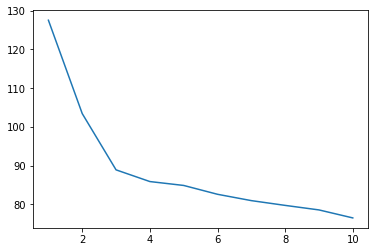

In [58]:
plt.plot(list(elbow.keys()), list(elbow.values()))

#### From the previous plot we can figure out what's the best k for me... We will implement the kmeans algorithm for the specific k

In [60]:
best = kmeans(data, 3)

for t in range(100):
    
    C = kmeans(data, 3)
    
    if dissimilarity(C[0]) < dissimilarity(best[0]):
        
        best = C
        
outcome = []

for i in range(data.shape[0]):
    
    outcome.append(best[1][i][0] + 1)
    

#### We did the following commands for all the columns, and we observed that two columns/features have a big effect on the clustering of the other features. Here we will show the distribution of the features, when plotted with Magnesium and  Total Phenols

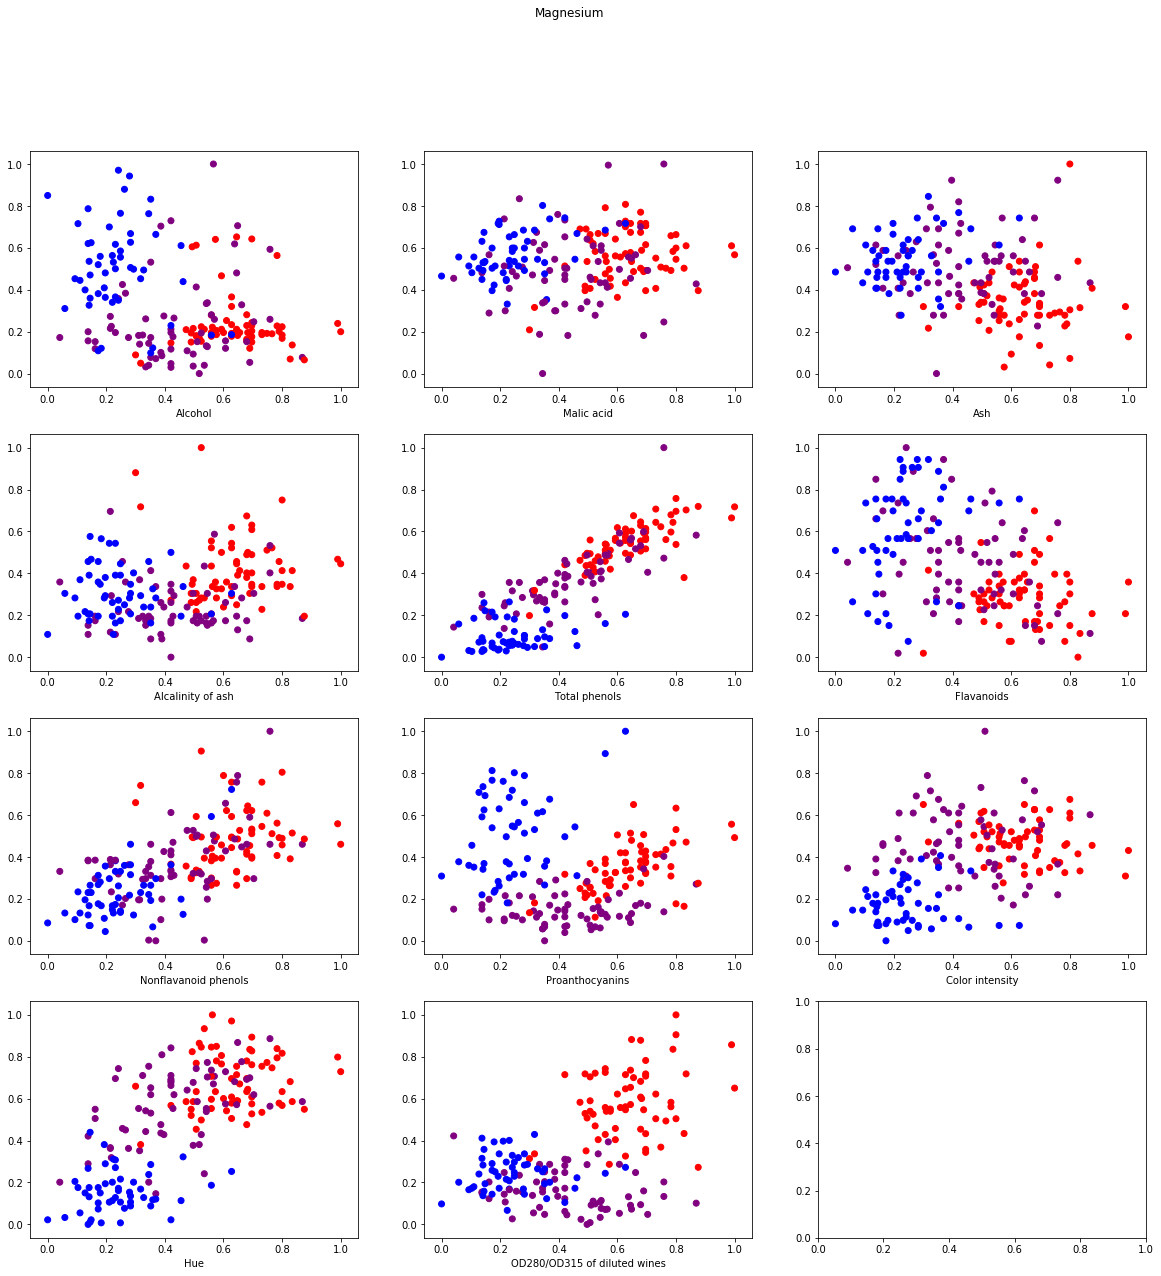

In [63]:
f, axes = plt.subplots(4,3,figsize=(20,20))

axes[0][0].scatter(data[:, 5], data[:, 1], c=outcome, cmap=matplotlib.colors.ListedColormap(["purple", "blue", "red"]))
axes[0][0].set_xlabel(header[1])

axes[0][1].scatter(data[:, 5], data[:, 2], c=outcome, cmap=matplotlib.colors.ListedColormap(["purple", "blue", "red"]))
axes[0][1].set_xlabel(header[2])

axes[0][2].scatter(data[:, 5], data[:, 3], c=outcome, cmap=matplotlib.colors.ListedColormap(["purple", "blue", "red"]))
axes[0][2].set_xlabel(header[3])

axes[1][0].scatter(data[:, 5], data[:, 4], c=outcome, cmap=matplotlib.colors.ListedColormap(["purple", "blue", "red"]))
axes[1][0].set_xlabel(header[4])

axes[1][1].scatter(data[:, 5], data[:, 6], c=outcome, cmap=matplotlib.colors.ListedColormap(["purple", "blue", "red"]))
axes[1][1].set_xlabel(header[6])

axes[1][2].scatter(data[:, 5], data[:, 7], c=outcome, cmap=matplotlib.colors.ListedColormap(["purple", "blue", "red"]))
axes[1][2].set_xlabel(header[7])

axes[2][0].scatter(data[:, 5], data[:, 8], c=outcome, cmap=matplotlib.colors.ListedColormap(["purple", "blue", "red"]))
axes[2][0].set_xlabel(header[8])

axes[2][1].scatter(data[:, 5], data[:, 9], c=outcome, cmap=matplotlib.colors.ListedColormap(["purple", "blue", "red"]))
axes[2][1].set_xlabel(header[9])

axes[2][2].scatter(data[:, 5], data[:, 10], c=outcome, cmap=matplotlib.colors.ListedColormap(["purple", "blue", "red"]))
axes[2][2].set_xlabel(header[10])

axes[3][0].scatter(data[:, 5], data[:, 11], c=outcome, cmap=matplotlib.colors.ListedColormap(["purple", "blue", "red"]))
axes[3][0].set_xlabel(header[11])

axes[3][1].scatter(data[:, 5], data[:, 12], c=outcome, cmap=matplotlib.colors.ListedColormap(["purple", "blue", "red"]))
axes[3][1].set_xlabel(header[12])

plt.suptitle(header[5])

plt.show()

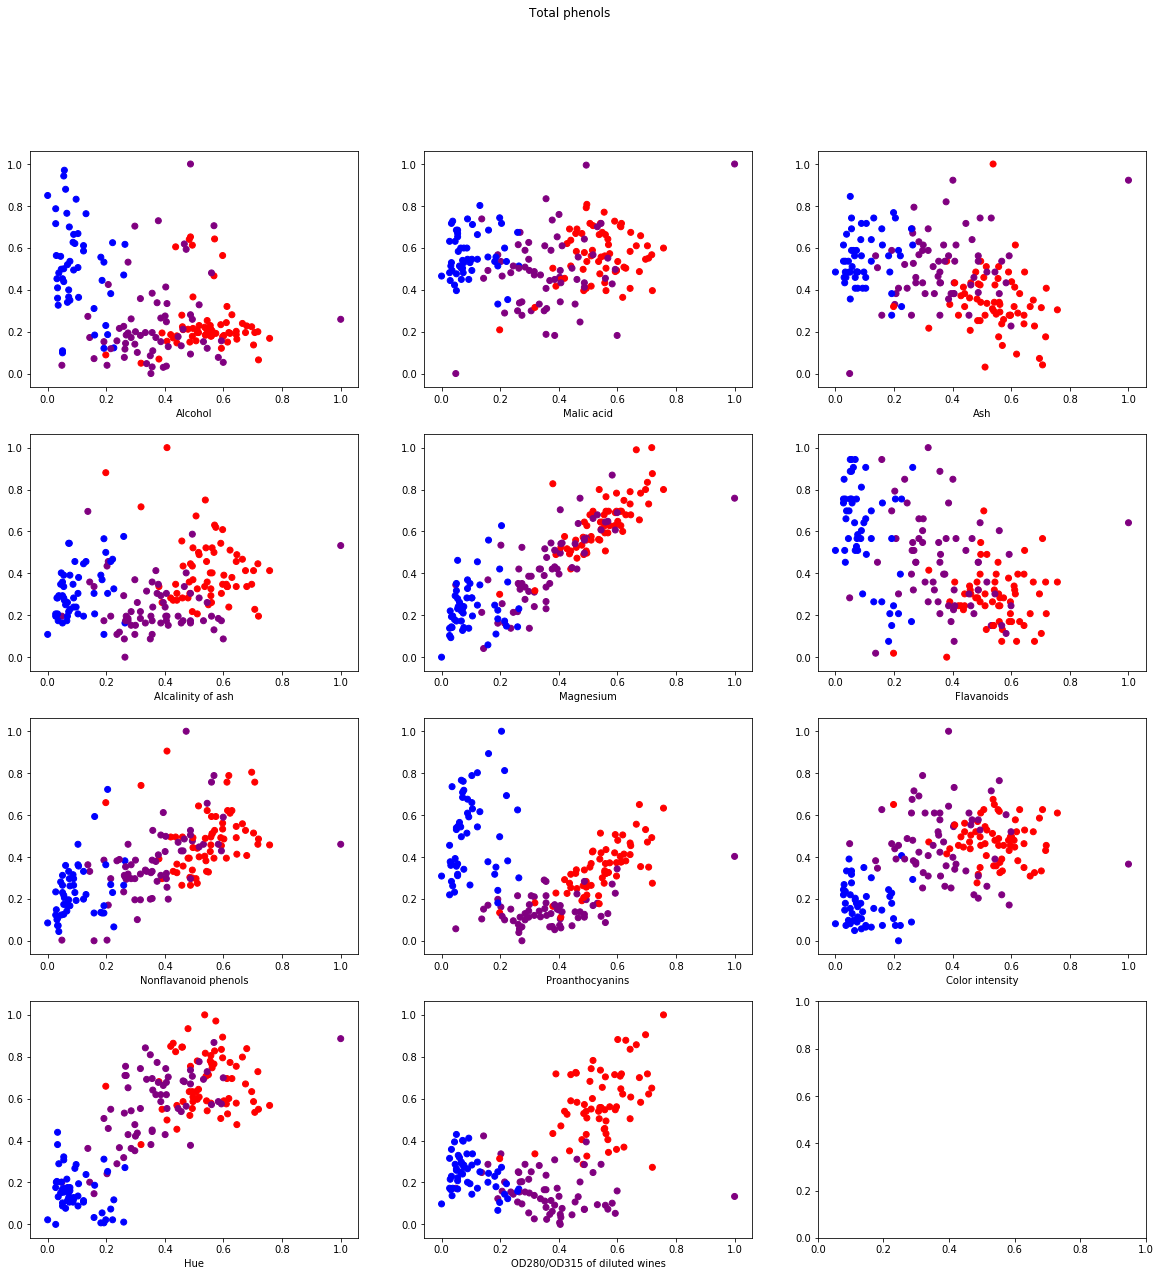

In [65]:
f, axes = plt.subplots(4,3,figsize=(20,20))

axes[0][0].scatter(data[:, 6], data[:, 1], c=outcome, cmap=matplotlib.colors.ListedColormap(["purple", "blue", "red"]))
axes[0][0].set_xlabel(header[1])

axes[0][1].scatter(data[:, 6], data[:, 2], c=outcome, cmap=matplotlib.colors.ListedColormap(["purple", "blue", "red"]))
axes[0][1].set_xlabel(header[2])

axes[0][2].scatter(data[:, 6], data[:, 3], c=outcome, cmap=matplotlib.colors.ListedColormap(["purple", "blue", "red"]))
axes[0][2].set_xlabel(header[3])

axes[1][0].scatter(data[:, 6], data[:, 4], c=outcome, cmap=matplotlib.colors.ListedColormap(["purple", "blue", "red"]))
axes[1][0].set_xlabel(header[4])

axes[1][1].scatter(data[:, 6], data[:, 5], c=outcome, cmap=matplotlib.colors.ListedColormap(["purple", "blue", "red"]))
axes[1][1].set_xlabel(header[5])

axes[1][2].scatter(data[:, 6], data[:, 7], c=outcome, cmap=matplotlib.colors.ListedColormap(["purple", "blue", "red"]))
axes[1][2].set_xlabel(header[7])

axes[2][0].scatter(data[:, 6], data[:, 8], c=outcome, cmap=matplotlib.colors.ListedColormap(["purple", "blue", "red"]))
axes[2][0].set_xlabel(header[8])

axes[2][1].scatter(data[:, 6], data[:, 9], c=outcome, cmap=matplotlib.colors.ListedColormap(["purple", "blue", "red"]))
axes[2][1].set_xlabel(header[9])

axes[2][2].scatter(data[:, 6], data[:, 10], c=outcome, cmap=matplotlib.colors.ListedColormap(["purple", "blue", "red"]))
axes[2][2].set_xlabel(header[10])

axes[3][0].scatter(data[:, 6], data[:, 11], c=outcome, cmap=matplotlib.colors.ListedColormap(["purple", "blue", "red"]))
axes[3][0].set_xlabel(header[11])

axes[3][1].scatter(data[:, 6], data[:, 12], c=outcome, cmap=matplotlib.colors.ListedColormap(["purple", "blue", "red"]))
axes[3][1].set_xlabel(header[12])

plt.suptitle(header[6])

plt.show()

# 4. K-means can go wrong!

Clustring problem is non-linear over the $S \in (R^{d})^{K}$ where $d$ is the number of features in the dataset and $K$ is the number clusters. This problem can turn to linear form with binary variables while the $\hat{S} \in S$ only cosists of the points in the dataset. This problem can be formulated as K-median problem that is in familiy of MILP (Mixed Integer Linear Programming)
Since the K-median is MILP, algorithm like Branch & Bound can quarntee the global optimum over $\hat{S}$. In K-median, each centroid is one of the point in the dataset and it minimize the summation of the distance to corresponding centroids. So if K-median find the solution $\hat{X}$ with $Cost(\hat{X})$ that is less than $Cost(X)$ where $X$ is the solution stem from K-means we can say that K-means fails to find the global optimum ($Global\: optimum \: \leq Cost(\hat{X})\:< Cost(X)$ [Link](https://stats.stackexchange.com/questions/48757/why-doesnt-k-means-give-the-global-minimum). 

### K-median formulation

$x_{i,j} = 1 \: \: \text{if point i is in cluster} \: c_j \: \text{that is} \: \: p_j \: \text{otherwise} \: 0$

$z_{j} = 1 \: \: \text{if} \: p_j \: \text{is a centroid otherwise} \: 0$

$d_{i,j} = \text{squared distance of point} \: i \: \text{and} \: j$

$Cost = \sum_{i}\sum_{j}{x_{i,j}d_{i,j}}$

subject to:

$x_{i,j} \leq z_{j} \:\:\forall i,j$

$\sum_{j}{x_{i,j}} = 1 \:\:\forall i$

$\sum_{j}{z_{j}} = K$

<img src="k-means-algorithm.png">

The above example shows the True clusters and possible solution we can get from K-means with different seed value. However K-median yeilds to the centroids with a bit higher Cost, but it found the true clusters while K-means fails.

### Example - Exercise 4

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_wine
import json
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize

wine = load_wine()
wine.target[[10, 80, 140]]

list(wine.target_names)

['class_0', 'class_1', 'class_2']

In [180]:
wine_df = pd.DataFrame(wine.data , columns= wine.feature_names)

wine_df['target'] =  wine.target

The real classes of the wines

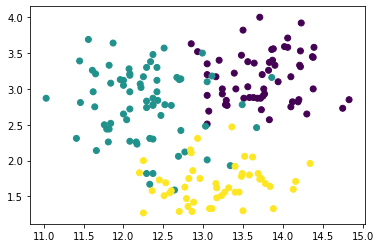

In [50]:
plt.scatter(wine_df['alcohol'] , wine_df['od280/od315_of_diluted_wines'] , c = wine_df['target'])
plt.show()

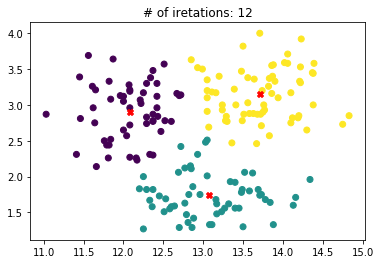

In [167]:
kmean = KMeans(n_clusters= 3, init = 'random' ).fit(wine_df[['alcohol', 'od280/od315_of_diluted_wines']])
plt.scatter(wine_df['alcohol'] , wine_df['od280/od315_of_diluted_wines'] , c = kmean.labels_)
plt.scatter( kmean.cluster_centers_[: , 0], kmean.cluster_centers_[: , 1] , marker='X' , c = 'r')
plt.title(label = '# of iretations: {}'.format(kmean.n_iter_ ) ,loc='center')
plt.show()

We can see after choosing approximate points of initializations it would be faster to do the clustering

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


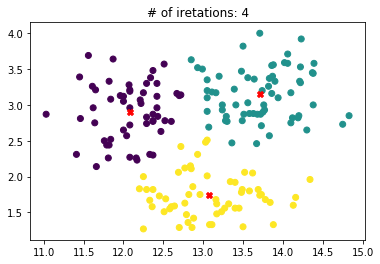

In [168]:
kmean = KMeans(n_clusters= 3, init = np.array([[12,3] ,[13,3] ,[13,1.7]]) ).fit(wine_df[['alcohol', 'od280/od315_of_diluted_wines']])
plt.scatter(wine_df['alcohol'] , wine_df['od280/od315_of_diluted_wines'] , c = kmean.labels_)
plt.scatter( kmean.cluster_centers_[: , 0], kmean.cluster_centers_[: , 1] , marker='X' , c = 'r')
plt.title(label = '# of iretations: {}'.format(kmean.n_iter_ ) ,loc='center')
plt.show()

## We can easily show how random initialization can effect on the number of iteration and the cost increases

In [178]:
for k in range(12):
    kmean = KMeans(n_clusters= 3, init = 'random' ).fit(wine_df[['alcohol', 'od280/od315_of_diluted_wines']])
    print('# of iretations: {}'.format(kmean.n_iter_ ) , 'And inertia: {}'.format(kmean.inertia_))

# of iretations: 7 And inertia: 58.32594553894382
# of iretations: 10 And inertia: 58.32594553894382
# of iretations: 9 And inertia: 58.32594553894382
# of iretations: 10 And inertia: 58.32594553894382
# of iretations: 8 And inertia: 58.32594553894382
# of iretations: 8 And inertia: 58.32594553894382
# of iretations: 8 And inertia: 58.32594553894382
# of iretations: 6 And inertia: 58.32594553894382
# of iretations: 12 And inertia: 58.32594553894382
# of iretations: 8 And inertia: 58.32594553894382
# of iretations: 6 And inertia: 58.32594553894382
# of iretations: 4 And inertia: 58.32594553894382
